# Erstelllung eines Modell-Fit der WPL13E mit ausführlichen Referenz-Daten
- Daten stammen aus dem Installationshandbuch der Wärmepumpe und weiseneinen breiten Bereich (-20°C bis + 40°C) auf.
- Es werden folgende Fit-Funktionen mit verschiedener Parameter-Anzahl (p1 ... p9) evaluiert
1. **simple**       z = p1x + p2y + p3
2. **complex1**     z = p1x + p2y + p3xy + p4
3. **complex2**     z = doppelt quadratisch mit p1 bis p9

Die Vorgehensweise soll grundsätzlich zeigen, dass sich die Fit-Methoden bei ausreichenden Datenbasis eignen und das es wichtig ist, den COP oder die Heizleistung nicht ausschließlich von der Temperatur-Differenz zwischen Quelle und Senke abhängig zu machen, sondern von den konkreten Quell- und Zieltemperaturen.

Darüber hinaus soll identifiziert werden, welche zwei der vier Variablen  (P_el, P_th, COP, eta) sich am besten/einfachsten/robustesten fitten lassen. Die anderen zwei Variablen lassen sich dann berechnen. 

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import curve_fit
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib widget

In [2]:
# Funktion zum fitten
# x=T_in, y=T_out, z=Größe zum fitten

def fit_simple(x,y,z):
    p0=[0.1,0.001,1.] # Startwerte
    a=(x,y,z) 
    para,_ = scipy.optimize.leastsq(func_simple_zero,p0,args=a)
    return para

def func_simple_zero(para, x, y, z):
    k1,k2,k3 = para
    z_calc = k1*x + k2*y + k3
    z_diff = z_calc - z
    return z_diff

def fit_complex(x, y, z, order):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
        para, _, _, _ = np.linalg.lstsq(G, z, rcond=None)
    return para

# Funktion zum berechnen von z mittels Parametern und belibigen x und y
def func_simple(para, x, y):
    k1,k2,k3 = para
    z = k1*x + k2*y + k3
    return z

def func_complex(para, x, y):
    order = int(np.sqrt(len(para))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(para, ij):
        z += a * x**i * y**j
    return z

## Import der Referenz-Daten
Mit Hilfe des EngaugeDigitizer wurden die Referenz-Werte der Stiebel Eltron WPL 13 E aus der Grafik in eine CSV überführt.
BEDIENUNG UND INSTALLATION | LUFT/WASSER-WÄRMEPUMPE | WPL 13 cool, WPL 18 cool, WPL 23 cool, WPL 13 E, WPL 18 E, WPL 23 E

In [3]:
# Import data
data = pd.read_csv('heatpump_wpl13_diagramm.csv', delimiter=';', decimal=',')
# Daten vervollständigen, indem COP und Gütagrad (eta) aus errechnet werden
K = 273.15
data['T_in'] = data['T_in'].astype(float)
data['T_out'] = data['T_out'].astype(float)
data['COP'] = data['P_th'] / data['P_el']
eta_carnot = (data['T_out']+K) / ((data['T_out']+K)-(data['T_in']+K))
data['eta'] = data ['COP'] / eta_carnot
data.fillna(0, inplace=True)
data

,T_in,T_out,P_th,P_el,COP,eta
0,-19.8932,35.0,4.4916,2.0880,2.151149,0.383201
1,-19.6797,35.0,4.5276,2.0878,2.168599,0.384807
2,-19.4662,35.0,4.5640,2.0876,2.186243,0.386423
3,-19.3594,35.0,4.5825,2.0875,2.195210,0.387247
4,-19.2794,35.0,4.5964,2.0875,2.201868,0.387850
...,...,...,...,...,...,...
562,39.0925,65.0,13.9126,3.8554,3.608601,0.276474
563,39.2794,65.0,13.9123,3.8537,3.610115,0.274595
564,39.3327,65.0,13.9122,3.8532,3.610557,0.274060
565,39.5996,65.0,13.9118,3.8507,3.612798,0.271378


## Fitten der verschiedenen Größen P_el, P_th, COP und eta

In [4]:
# Daten fitten und vergleichen für P_el
var='P_el'
# simple
vars()[var+'_para_s'] = fit_simple(data['T_in'],data['T_out'],data[var])
data[var+'_s'] = func_simple(globals()[var+'_para_s'], data['T_in'], data['T_out'])
data[var+'_s_err'] = (data[var+'_s'] - data[var]) / data[var] * 100
d = {'simple': [data[var+'_s_err'].mean(), data[var+'_s_err'].max(), data[var+'_s_err'].min()]}
vars()[var+'_err'] = pd.DataFrame(d, index=['mean', 'max', 'min'])
# complex 1st
vars()[var+'_para_c1'] = fit_complex(data['T_in'],data['T_out'],data[var],1)
data[var+'_c1'] = func_complex(globals()[var+'_para_c1'], data['T_in'], data['T_out'])
data[var+'_c1_err'] = (data[var+'_c1'] - data[var]) / data[var] * 100
d = [data[var+'_c1_err'].mean(), data[var+'_c1_err'].max(), data[var+'_c1_err'].min()]
vars()[var+'_err']['complex1'] = d
# complex 2nd
vars()[var+'_para_c2'] = fit_complex(data['T_in'],data['T_out'],data[var],2)
data[var+'_c2'] = func_complex(globals()[var+'_para_c2'], data['T_in'], data['T_out'])
data[var+'_c2_err'] = (data[var+'_c2'] - data[var]) / data[var] * 100
d = [data[var+'_c2_err'].mean(), data[var+'_c2_err'].max(), data[var+'_c2_err'].min()]
vars()[var+'_err']['complex2'] = d
# Fehler in Prozent
globals()[var+'_err']

,simple,complex1,complex2
mean,0.082055,0.066103,0.059998
max,6.422579,6.422579,6.482257
min,-6.016977,-5.776300,-6.276890


In [5]:
# Daten fitten und vergleichen für P_th
var='P_th'
# simple
vars()[var+'_para_s'] = fit_simple(data['T_in'],data['T_out'],data[var])
data[var+'_s'] = func_simple(globals()[var+'_para_s'], data['T_in'], data['T_out'])
data[var+'_s_err'] = (data[var+'_s'] - data[var]) / data[var] * 100
d = {'simple': [data[var+'_s_err'].mean(), data[var+'_s_err'].max(), data[var+'_s_err'].min()]}
vars()[var+'_err'] = pd.DataFrame(d, index=['mean', 'max', 'min'])
# complex 1st
vars()[var+'_para_c1'] = fit_complex(data['T_in'],data['T_out'],data[var],1)
data[var+'_c1'] = func_complex(globals()[var+'_para_c1'], data['T_in'], data['T_out'])
data[var+'_c1_err'] = (data[var+'_c1'] - data[var]) / data[var] * 100
d = [data[var+'_c1_err'].mean(), data[var+'_c1_err'].max(), data[var+'_c1_err'].min()]
vars()[var+'_err']['complex1'] = d
# complex 2nd
vars()[var+'_para_c2'] = fit_complex(data['T_in'],data['T_out'],data[var],2)
data[var+'_c2'] = func_complex(globals()[var+'_para_c2'], data['T_in'], data['T_out'])
data[var+'_c2_err'] = (data[var+'_c2'] - data[var]) / data[var] * 100
d = [data[var+'_c2_err'].mean(), data[var+'_c2_err'].max(), data[var+'_c2_err'].min()]
vars()[var+'_err']['complex2'] = d
# Fehler in Prozent
globals()[var+'_err']

,simple,complex1,complex2
mean,0.047747,0.022324,0.074150
max,11.374359,11.374359,10.067284
min,-9.944200,-7.287193,-6.741507


In [6]:
# Daten fitten und vergleichen für COP
var='COP'
# simple
vars()[var+'_para_s'] = fit_simple(data['T_in'],data['T_out'],data[var])
data[var+'_s'] = func_simple(globals()[var+'_para_s'], data['T_in'], data['T_out'])
data[var+'_s_err'] = (data[var+'_s'] - data[var]) / data[var] * 100
d = {'simple': [data[var+'_s_err'].mean(), data[var+'_s_err'].max(), data[var+'_s_err'].min()]}
vars()[var+'_err'] = pd.DataFrame(d, index=['mean', 'max', 'min'])
# complex 1st
vars()[var+'_para_c1'] = fit_complex(data['T_in'],data['T_out'],data[var],1)
data[var+'_c1'] = func_complex(globals()[var+'_para_c1'], data['T_in'], data['T_out'])
data[var+'_c1_err'] = (data[var+'_c1'] - data[var]) / data[var] * 100
d = [data[var+'_c1_err'].mean(), data[var+'_c1_err'].max(), data[var+'_c1_err'].min()]
vars()[var+'_err']['complex1'] = d
# complex 2nd
vars()[var+'_para_c2'] = fit_complex(data['T_in'],data['T_out'],data[var],2)
data[var+'_c2'] = func_complex(globals()[var+'_para_c2'], data['T_in'], data['T_out'])
data[var+'_c2_err'] = (data[var+'_c2'] - data[var]) / data[var] * 100
d = [data[var+'_c2_err'].mean(), data[var+'_c2_err'].max(), data[var+'_c2_err'].min()]
vars()[var+'_err']['complex2'] = d
# Fehler in Prozent
globals()[var+'_err']

,simple,complex1,complex2
mean,-0.018841,0.166175,0.070505
max,16.773628,9.336702,10.760222
min,-22.019088,-7.636786,-5.728485


In [7]:
# Daten fitten und vergleichen für eta
var='eta'
# simple
vars()[var+'_para_s'] = fit_simple(data['T_in'],data['T_out'],data[var])
data[var+'_s'] = func_simple(globals()[var+'_para_s'], data['T_in'], data['T_out'])
data[var+'_s_err'] = (data[var+'_s'] - data[var]) / data[var] * 100
d = {'simple': [data[var+'_s_err'].mean(), data[var+'_s_err'].max(), data[var+'_s_err'].min()]}
vars()[var+'_err'] = pd.DataFrame(d, index=['mean', 'max', 'min'])
# complex 1st
vars()[var+'_para_c1'] = fit_complex(data['T_in'],data['T_out'],data[var],1)
data[var+'_c1'] = func_complex(globals()[var+'_para_c1'], data['T_in'], data['T_out'])
data[var+'_c1_err'] = (data[var+'_c1'] - data[var]) / data[var] * 100
d = [data[var+'_c1_err'].mean(), data[var+'_c1_err'].max(), data[var+'_c1_err'].min()]
vars()[var+'_err']['complex1'] = d
# complex 2nd
vars()[var+'_para_c2'] = fit_complex(data['T_in'],data['T_out'],data[var],2)
data[var+'_c2'] = func_complex(globals()[var+'_para_c2'], data['T_in'], data['T_out'])
data[var+'_c2_err'] = (data[var+'_c2'] - data[var]) / data[var] * 100
d = [data[var+'_c2_err'].mean(), data[var+'_c2_err'].max(), data[var+'_c2_err'].min()]
vars()[var+'_err']['complex2'] = d
# Fehler in Prozent
globals()[var+'_err']

,simple,complex1,complex2
mean,-13.600930,-8.128617,0.407049
max,6476.229045,3273.045380,145.564231
min,-11200.493919,-5708.186036,-227.382269


In [8]:
# Parameter abspeichern
para_wpl13_s = pd.DataFrame(index=['p1', 'p2', 'p3'])
para_wpl13_c1 = pd.DataFrame(index=['p1', 'p2', 'p3', 'p4'])
para_wpl13_c2 = pd.DataFrame(index=['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9'])
para_wpl13_s['P_el']=P_el_para_s
para_wpl13_c1['P_el']=P_el_para_c1
para_wpl13_c2['P_el']=P_el_para_c2
para_wpl13_s['P_th']=P_th_para_s
para_wpl13_c1['P_th']=P_th_para_c1
para_wpl13_c2['P_th']=P_th_para_c2
para_wpl13_s['COP']=COP_para_s
para_wpl13_c1['COP']=COP_para_c1
para_wpl13_c2['COP']=COP_para_c2
para_wpl13_s['eta']=eta_para_s
para_wpl13_c1['eta']=eta_para_c1
para_wpl13_c2['eta']=eta_para_c2
#para_wpl13_s.to_csv('para_wpl13_s_diaramm.csv')
#para_wpl13_c1.to_csv('para_wpl13_c1_diagramm.csv')
#para_wpl13_c2.to_csv('para_wpl13_c2_diagramm.csv')

 ## Vergleich der der Referenz-Daten mit den Ergebnissen der Fit-Funktionen 

Text(0, 0.5, 'eta')

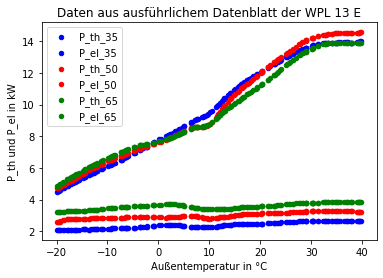

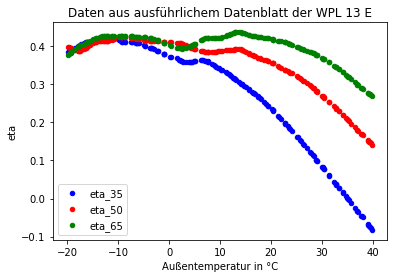

In [10]:
# Plot der Referenz-Daten
data2 = data # Kopie erstellen
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_35', c='Blue', title='Daten aus ausführlichem Datenblatt der WPL 13 E')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_35', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_50', c='Red')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_65', c='Green')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_65', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("P_th und P_el in kW")
#eta
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_35', c='Blue', title='Daten aus ausführlichem Datenblatt der WPL 13 E')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_65', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("eta")

Text(0, 0.5, 'P_el in kW')

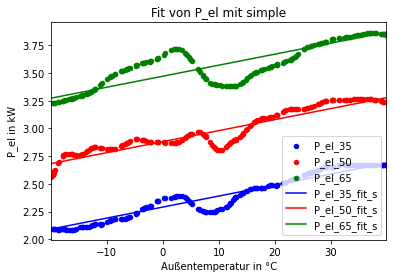

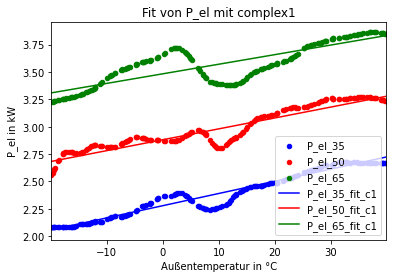

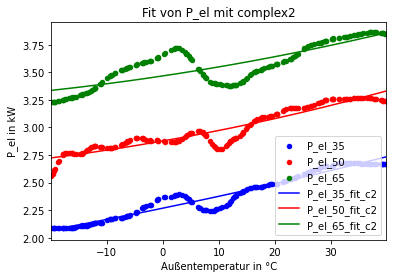

In [12]:
# P_el vergleichen
# Berechnen
data2['P_el_s'] = func_simple(para_wpl13_s['P_el'], data2['T_in'], data2['T_out'])
data2['P_el_c1'] = func_complex(para_wpl13_c1['P_el'], data2['T_in'], data2['T_out'])
data2['P_el_c2'] = func_complex(para_wpl13_c2['P_el'], data2['T_in'], data2['T_out'])
# Plot Simple
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_35', c='Blue', title='Fit von P_el mit simple')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_el_s', kind='line', label='P_el_35_fit_s', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_el_s', kind='line', label='P_el_50_fit_s', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_el_s', kind='line', label='P_el_65_fit_s', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("P_el in kW")
# Complex1
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_35', c='Blue', title='Fit von P_el mit complex1')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_el_c1', kind='line', label='P_el_35_fit_c1', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_el_c1', kind='line', label='P_el_50_fit_c1', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_el_c1', kind='line', label='P_el_65_fit_c1', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("P_el in kW")
# Complex2
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_35', c='Blue', title='Fit von P_el mit complex2')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_el', kind='scatter', label='P_el_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_el_c2', kind='line', label='P_el_35_fit_c2', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_el_c2', kind='line', label='P_el_50_fit_c2', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_el_c2', kind='line', label='P_el_65_fit_c2', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("P_el in kW")

### Fazit für P_el: einfacher Fit (simple / _s) ist aureichend 

Text(0, 0.5, 'P_th in kW')

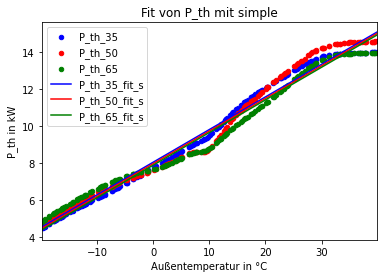

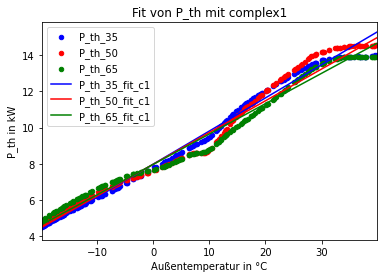

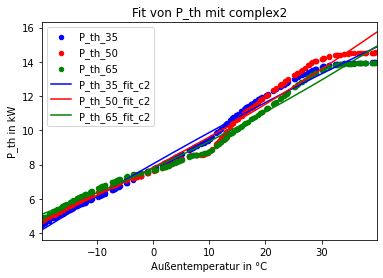

In [13]:
# P_th vergleichen
data2['P_th_s'] = func_simple(para_wpl13_s['P_th'], data2['T_in'], data2['T_out'])
data2['P_th_c1'] = func_complex(para_wpl13_c1['P_th'], data2['T_in'], data2['T_out'])
data2['P_th_c2'] = func_complex(para_wpl13_c2['P_th'], data2['T_in'], data2['T_out'])
# Simple
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_35', c='Blue', title='Fit von P_th mit simple')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_th_s', kind='line', label='P_th_35_fit_s', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_th_s', kind='line', label='P_th_50_fit_s', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_th_s', kind='line', label='P_th_65_fit_s', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("P_th in kW")
# Complex1
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_35', c='Blue', title='Fit von P_th mit complex1')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_th_c1', kind='line', label='P_th_35_fit_c1', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_th_c1', kind='line', label='P_th_50_fit_c1', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_th_c1', kind='line', label='P_th_65_fit_c1', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("P_th in kW")
# Complex2
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_35', c='Blue', title='Fit von P_th mit complex2')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_th', kind='scatter', label='P_th_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='P_th_c2', kind='line', label='P_th_35_fit_c2', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='P_th_c2', kind='line', label='P_th_50_fit_c2', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='P_th_c2', kind='line', label='P_th_65_fit_c2', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("P_th in kW")

### Fazit: Erwartungsgemäß kann kein Fit den unstetigen Verlauf richtig nachbilden. Die grundsätzliche Abhängigkeit der Heizleistung von der Außtentemperatur wird jedoch bereits mit dem einfachen Fit (simple / _s) ausreichend abgebildet, auch wenn complex2 vor allem im Bereich kalter Quelltemperaturen nochmal genauer ist.

Text(0, 0.5, 'COP')

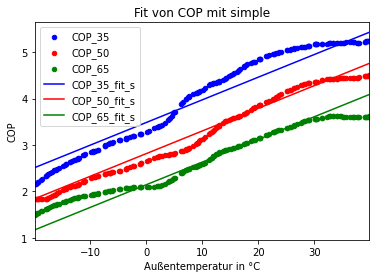

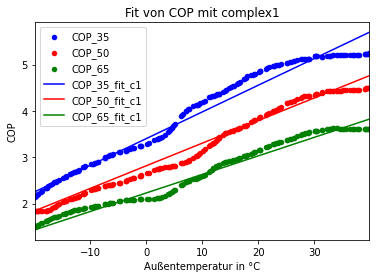

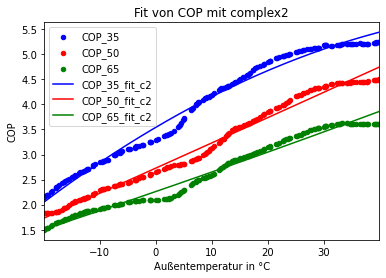

In [14]:
# COP vergleichen
data2['COP_s'] = func_simple(para_wpl13_s['COP'], data2['T_in'], data2['T_out'])
data2['COP_c1'] = func_complex(para_wpl13_c1['COP'], data2['T_in'], data2['T_out'])
data2['COP_c2'] = func_complex(para_wpl13_c2['COP'], data2['T_in'], data2['T_out'])
# Simple
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_35', c='Blue', title='Fit von COP mit simple')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='COP_s', kind='line', label='COP_35_fit_s', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='COP_s', kind='line', label='COP_50_fit_s', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='COP_s', kind='line', label='COP_65_fit_s', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("COP")
# Complex1
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_35', c='Blue', title='Fit von COP mit complex1')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='COP_c1', kind='line', label='COP_35_fit_c1', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='COP_c1', kind='line', label='COP_50_fit_c1', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='COP_c1', kind='line', label='COP_65_fit_c1', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("COP")
# Complex2
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_35', c='Blue', title='Fit von COP mit complex2')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='COP', kind='scatter', label='COP_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='COP_c2', kind='line', label='COP_35_fit_c2', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='COP_c2', kind='line', label='COP_50_fit_c2', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='COP_c2', kind='line', label='COP_65_fit_c2', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("COP")

### Fazit: Hier ist complex2-Fit deutlich im Vorteil. Idee könnte also sein, den COP zu fitten und mit dem Fit der elektrischen Leistung in thermische Leistung umzurechnen. Sollte sich der Gütegrad noch besser fitten lassen, als der COP, sollte man dessen Fit verwenden.

Text(0, 0.5, 'Gütegrad (eta)')

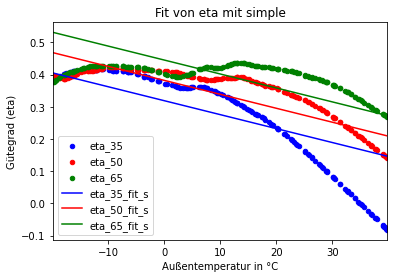

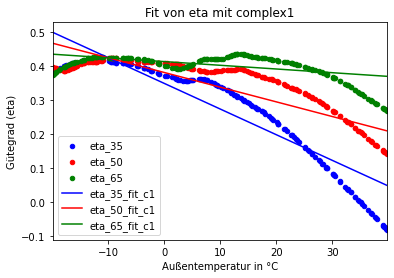

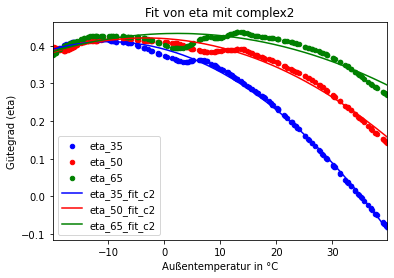

In [15]:
# Eta vergleichen
data2['eta_s'] = func_simple(para_wpl13_s['eta'], data2['T_in'], data2['T_out'])
data2['eta_c1'] = func_complex(para_wpl13_c1['eta'], data2['T_in'], data2['T_out'])
data2['eta_c2'] = func_complex(para_wpl13_c2['eta'], data2['T_in'], data2['T_out'])
# Simple
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_35', c='Blue', title='Fit von eta mit simple')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='eta_s', kind='line', label='eta_35_fit_s', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='eta_s', kind='line', label='eta_50_fit_s', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='eta_s', kind='line', label='eta_65_fit_s', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("Gütegrad (eta)")
# Complex1
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_35', c='Blue', title='Fit von eta mit complex1')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='eta_c1', kind='line', label='eta_35_fit_c1', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='eta_c1', kind='line', label='eta_50_fit_c1', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='eta_c1', kind='line', label='eta_65_fit_c1', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("Gütegrad (eta)")
# Complex2
fig, axes = plt.subplots(nrows=1, ncols=1)
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_35', c='Blue', title='Fit von eta mit complex2')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_50', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='eta', kind='scatter', label='eta_65', c='Green')
data2[data2['T_out']==35].plot(ax=axes, x='T_in', y='eta_c2', kind='line', label='eta_35_fit_c2', c='Blue')
data2[data2['T_out']==50].plot(ax=axes, x='T_in', y='eta_c2', kind='line', label='eta_50_fit_c2', c='Red')
data2[data2['T_out']==65].plot(ax=axes, x='T_in', y='eta_c2', kind='line', label='eta_65_fit_c2', c='Green')
axes.set_xlabel("Außentemperatur in °C")
axes.set_ylabel("Gütegrad (eta)")

### Fazit: Es zeigt sich, dass nur der Fit complex2 geeignet wäre. Da ein schlechter fit schnell zu negativen Werten für den Gütegrad führen kann, wird jedoch empfohlen lieber den COP zu fitten.

# Weitere Vorgehensweise
Ziel ist es zukünftig mit den wenigen Stützstellen des Heatpumpkeymark und einem robusten/möglichst gutem Fit-Verfahren das energetische Verhalten von Wärmepumpen hinreichend genau abzubilden.

In einem weiteren Notebook wird nun überprüft, wie gut das für die hier untersuchte Stiebel Eltron WPL13 E funktioniert. Anschließend wird auf Basis der öffentlich zugänglichen Datenbank des Heatpumpkeymark einen Datenbank aufgebaut.